In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Let's define a simple function that takes a single value $x$ and returns a value

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

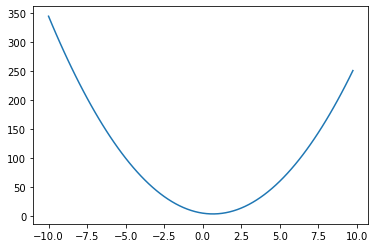

In [4]:
xs = np.arange(-10, 10, 0.25)
ys = f(xs)
plt.plot(xs, ys)

What is the derivative of this function? 

* We can write a formula of the derivative but we would not use this symbolic approach, we go towards the definition of a derivative: $$L=\lim_{h \to 0}\frac{f(a+h)-f(a)}h $$

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

this is a numeric approximation of the derivative value of $f(x)$ at the value $x$

Let's go more complex...

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Let's look at the derivative wrt to $c$....We add to $c$ the infinitesimal increment $h$ and we evaluate the difference among the output of the function normalized by $h$

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [198]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label

        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [199]:
Value(3.0)*Value(2.9)

Value(data=8.7, grad=0)

In [200]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

$$ L = d * f $$

$$ dL / dd = f $$

$$ (f(x+h)-f(x))/h = ((d+h)*f - d*f) / h = (d*f+h*f-d*f)/h = f $$

In [201]:
def lol():
    
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
    
print(lol())

6.000000000128124
None


dL / dc = dL/dd * dd/dc

dd / dc = (c+h+e - c-e) / h = 1.0 

dL / dd = (h*f+d*f-d*f) / h = f  so

dL / dc = f * 1.0

In [202]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


Value(data=Value(data=Value(data=-47.52549434807817, grad=0), grad=0), grad=0)


In [203]:
def lol():
  
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


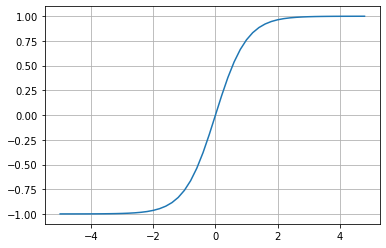

In [204]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [205]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [206]:
o.backward()

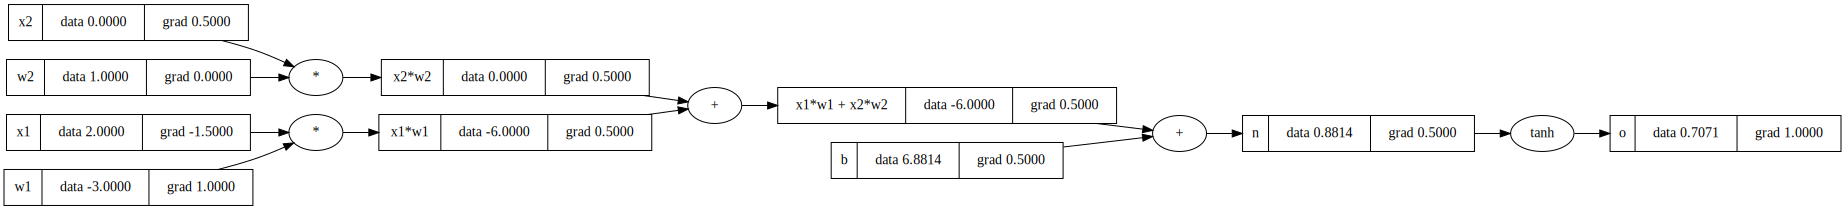

In [207]:
draw_dot(o)

In [208]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# -------------------------------
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'

o.backward()

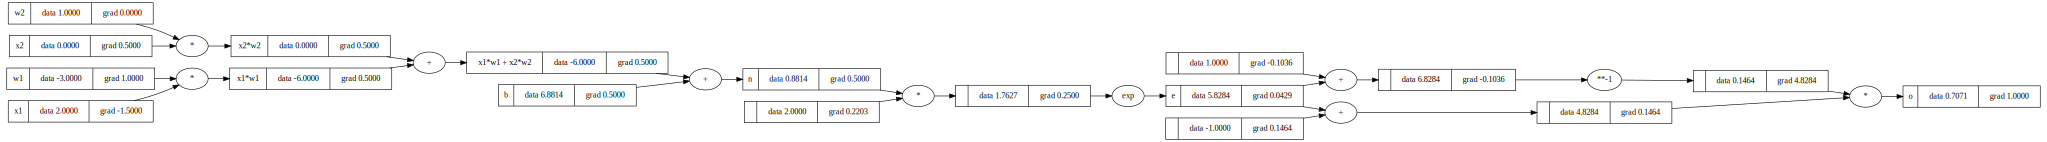

In [209]:
draw_dot(o)

In [210]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [220]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [221]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7052752162430139, grad=0)

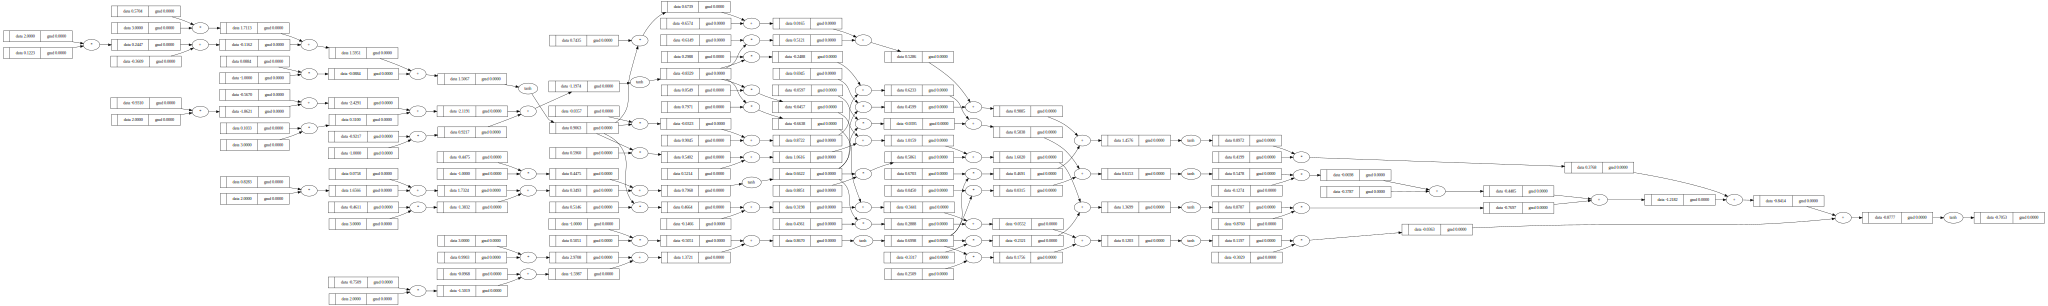

In [222]:
out = n(x)
draw_dot(out)

In [223]:
out

Value(data=-0.7052752162430139, grad=0)

In [537]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4, 4, 1])

In [563]:
for k in range(50):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)))

    # zero grad
    for p in n.parameters():
        p.grad = 0
    
    # backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.0005735887978740423
1 0.0005720161068496651
2 0.0005704517511964407
3 0.0005688956656264975
4 0.0005673477855275278
5 0.0005658080469540983
6 0.0005642763866191009
7 0.0005627527418853604
8 0.0005612370507573211
9 0.000559729251872901
10 0.000558229284495454
11 0.0005567370885058423
12 0.0005552526043946724
13 0.0005537757732545792
14 0.0005523065367726938
15 0.0005508448372231663
16 0.0005493906174598596
17 0.0005479438209090952
18 0.0005465043915625515
19 0.0005450722739702309
20 0.0005436474132335616
21 0.0005422297549985855
22 0.0005408192454492374
23 0.0005394158313007766
24 0.0005380194597932096
25 0.0005366300786849223
26 0.0005352476362463458
27 0.0005338720812537004
28 0.000532503362982899
29 0.0005311414312034397
30 0.0005297862361724952
31 0.0005284377286289855
32 0.0005270958597878263
33 0.0005257605813341837
34 0.0005244318454178658
35 0.0005231096046477761
36 0.0005217938120864082
37 0.0005204844212445122
38 0.0005191813860757234
39 0.0005178846609713569
40 0.00051659

In [564]:
ypred

[Value(data=0.988621096540245, grad=-0.022757806919510015),
 Value(data=-0.9927371900798493, grad=0.01452561984030143),
 Value(data=-0.9895767765783198, grad=0.020846446843360456),
 Value(data=0.9853581663038887, grad=-0.029283667392222545)]